In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import missingno as msno
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

%matplotlib inline

In [5]:
data = pd.read_csv('../credit_card_kaggle/creditcard.csv')
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print('Dataset columns: {}'.format(data_cols))

minmaxscaler=MinMaxScaler()
minmaxscaler.fit(data[data_cols])
data[data_cols] = minmaxscaler.transform(data[data_cols])


data.head()

Dataset columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.000000,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.000006,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.000012,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Training VAE

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

import argparse
import os


In [7]:
# network parameters
original_dim= data.shape[1]-1
input_shape = (original_dim, )
intermediate_dim = int(original_dim/2)
batch_size = 128
latent_dim = 30
epochs     = 80
epsilon_std = 1.0

In [14]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [36]:
# # VAE Architecture
# # * original_dim - Original Input Dimension
# # * intermediate_dim - Hidden Layer Dimension
# # * latent_dim - Latent/Embedding Dimension
# def vae_arc(original_dim, intermediate_dim, latent_dim):
#     # Decode
#     decoder = Sequential([
#         Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
#         Dense(original_dim, activation='sigmoid')
#     ])

#     # Encode
#     x = Input(shape=(original_dim,))
#     h = Dense(intermediate_dim, activation='relu')(x)

#     z_mu = Dense(latent_dim)(h)
#     z_log_var = Dense(latent_dim)(h)

#     z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
#     z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

#     eps = Input(tensor=K.random_normal(stddev=epsilon_std,
#                                        shape=(K.shape(x)[0], latent_dim)))
#     z_eps = Multiply()([z_sigma, eps])
#     z = Add()([z_mu, z_eps])

#     x_pred = decoder(z)
    
#     return x, eps, z_mu, x_pred

In [10]:
# VAE Architecture
# * original_dim - Original Input Dimension
# * intermediate_dim - Hidden Layer Dimension
# * latent_dim - Latent/Embedding Dimension

def decoder(z):
    # Decode
    x_pred1 = Dense(intermediate_dim, input_dim=latent_dim, activation='relu')(z)
    x_pred2 = Dense(original_dim, activation='sigmoid') (x_pred1)
    return x_pred2

def vaeModel(original_dim, intermediate_dim, latent_dim):

    # Encode
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)

    z_mu = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
    z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

    eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                       shape=(K.shape(x)[0], latent_dim)))
    z_eps = Multiply()([z_sigma, eps])
    z = Add()([z_mu, z_eps])

    x_pred = decoder(z)
    
    return x, eps, z_mu, x_pred

In [11]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [65]:
x, eps, z_mu, x_pred = vaeModel(original_dim, intermediate_dim, latent_dim)
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

In [66]:
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 15)           465         input_13[0][0]                   
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 30)           480         dense_28[0][0]                   
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 30)           480         dense_28[0][0]                   
____________________________________________________________________________________________

In [15]:
#Train VAE

In [57]:
from sklearn.model_selection import train_test_split

# 
X_train, X_test, y_train, y_test = train_test_split(data[data_cols], data[label_cols], 
                                                    test_size=0.33, random_state=42)

In [58]:
X_train.shape,X_test.shape

((190820, 30), (93987, 30))

In [59]:
filepath   ="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [67]:
hist = vae.fit([X_train, X_train],
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks_list,
        validation_data=[X_test, X_test],verbose=1)

Epoch 1/80
1491/1491 [==============================] - 2s 893us/step - loss: 0.0311 - val_loss: 9.9080e-06

Epoch 00001: val_loss improved from inf to 0.00001, saving model to weights.hdf5
Epoch 2/80
1491/1491 [==============================] - 1s 774us/step - loss: 1.0526e-05 - val_loss: 3.1680e-06

Epoch 00002: val_loss improved from 0.00001 to 0.00000, saving model to weights.hdf5
Epoch 3/80
1491/1491 [==============================] - 1s 775us/step - loss: 2.2922e-06 - val_loss: 1.3952e-06

Epoch 00003: val_loss improved from 0.00000 to 0.00000, saving model to weights.hdf5
Epoch 4/80
1491/1491 [==============================] - 1s 789us/step - loss: 1.2432e-06 - val_loss: 7.8751e-07

Epoch 00004: val_loss improved from 0.00000 to 0.00000, saving model to weights.hdf5
Epoch 5/80
1491/1491 [==============================] - 1s 789us/step - loss: 8.0003e-07 - val_loss: 4.0045e-07

Epoch 00005: val_loss improved from 0.00000 to 0.00000, saving model to weights.hdf5
Epoch 6/80
1491/14

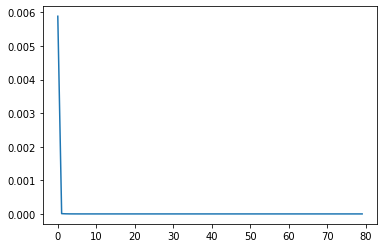

In [74]:
from matplotlib import pyplot as plt
plt.plot(hist.history['loss'])

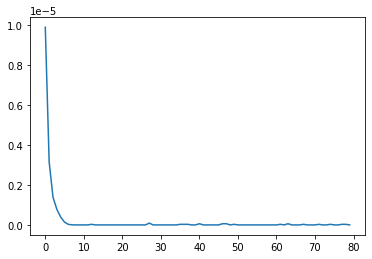

In [75]:
from matplotlib import pyplot as plt
plt.plot(hist.history['val_loss'])

In [15]:
from keras.models import load_model
vae = load_model('weights.hdf5')

ValueError: Unknown layer: KLDivergenceLayer

In [3]:
encoder = Model(x, z_mu)
z_df  = vae.predict(data.loc[0:100,data_cols], batch_size=batch_size)
x_pred = decoder(z_df)
pd.DataFrame(x_pred)

NameError: name 'Model' is not defined